# # The BBC News Glove(TF) vs Bert(TF-Pytorch) 

* The dataset includes 2225 News and all are labeled.
* There are 5 different label categories for these news.
* This dataset is very clean in terms of nlp because it is written by bbc editors. 
* Three different Neural Networks will be used to predict labels.
* I have created BERT with two different libraries to see different. I also more familiar with Tensorflow, so it helps to understand how Pytorch works.

*1) Glove Embeddings*
* Glove provides vector representation for words. I will use Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors).
* It basically provides 300 dimensinal vector. Every dimension represents different feature of word. For example, one is positivity value one is negativity and so on.
* This helps to create emmbedding matrix for Neural Network input.
* The bidirectional layer will be used in neural network. Bidirectional layer is impoartant to train nlp dataset because it trains the sentence or text as is and reversed of sentence.
* For example, "I like a bar that plays jazz music" - "I like a bar of white chocolate not small piece". As you can see first 3 words are same. If we don't train with bidirectional layers, we cannot understand real meaning of the bar.

*2) BERT*
* BERT stands for Bidirectional Encoder Representation from Transformers
* It is pretrained model and as you can see from its name, it pre-trained deep bidirectional with own embedding matrix.
* Bert has hidden state that has 768 dimensions that is similar to embedding matrix.
* BERT-Base-Uncased: 12-layers, 768-hidden_size, 12-heads, 110M parameters.
* The max number of tokens is 512 for BERT.


*References*
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/output#0.-Introduction-and-References
* https://www.kaggle.com/shoheiazuma/tweet-sentiment-roberta-pytorch
* https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch
* http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/    (Pictures)

* I have inspired from these notebooks. Please upvote them, as well.

# Import Libraries

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable = True , offline = False)


from transformers import AdamW
import transformers

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

from tqdm import tqdm

# Impporting Dataset
* Importing the dataset and found all class names.
* The labels are encoded with one hot encoding. 

In [ ]:
df = pd.read_csv('../input/bbc-fulltext-and-category/bbc-text.csv')

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['label'] = enc.fit_transform(df['category'])

class_names = df.groupby(['category', 'label']).count().reset_index().loc[:,['category', 'label']]
class_name_tokenizers = {}
for class_name in class_names.category:
    class_name_tokenizers[class_name] = [tokenizer.encode(class_name)[1],class_names[class_names['category'] == class_name]['label'].iloc[0]]

In [ ]:
#Class names are encoded one hot encoding method and encoded with Bert tokenizer.
class_name_tokenizers

In [ ]:
category_counts = df['category'].value_counts()
categories = category_counts.index

fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)
sns.barplot(x = category_counts.index , y = category_counts)
for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
plt.xlabel('Categories', size = 15)
plt.ylabel('The Number of News', size= 15)
plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)
plt.show()

# Cleaning the texts
* This dataset doesn't require a lot of cleaning because it has written by editor of BBC. There are not links special characters or emojis.
* If we work with twitter text, it needs lot of cleaning.
* Just two different condition added for cleaning. First is punctuation and second is stopwords.
* Punctuation is helping to split the special characters from the words. For example " $15bn " is becoming " 15 bn ". It is not necessary for Glove because it deletes all of them. Howevet, Bert needs them. Seperating punctuations is not compulsory for Bert because it is intelligent to seperate them, but not always, so we will do that to improve model. 

In [ ]:
def clean(text, punctuation = False, stopword = False):
    # filter to allow only alphabets
#    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    # Deleting Stopwords
    if stopword == True:
        text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
        text = text.split()
        text = [word for word in text if word not in stopw]
        text = " ".join(text)
    # Seperating the punctuations to tokenize them
    if punctuation == True:
        punc = '@#!?+&*[]-%.:/();$£=><|{}^'
        for p in punc:
            text = text.replace(p, f' {p} ')    

    # Urls
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"   ", " ", text)
    return text
      

In [ ]:
df['cleaned_from_stopw'] = df['text'].apply(lambda x : clean(x, stopword = True))
df['cleaned'] = df["text"].apply(lambda x : clean(x,punctuation = True))
df["count"] = df["cleaned"].apply(lambda x: len(x.split()))

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(df['count'] )
plt.xlim(0,1000)
plt.xlabel('The number of words', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

* The last 64 texts are splitted for test unseen data.

In [ ]:
df =df.iloc[:-64,:].reset_index(drop= True)
df_test = df.iloc[-64:,:].reset_index(drop= True)

# N-Grams
* This function returns the unique words(bigram) or sequence of words and its occurrence frequency.

In [ ]:
def create_n_gram(df, category= '',text_column = 'cleaned_from_stopw' ,n_gram = 1):
    n_gram_dict = {}
    if category != '':                                              # This condition is created in case of filtering the label.
        df = df[df['category'] == category]

    for k in tqdm(df['cleaned_from_stopw']):

        for i in range(len(k)):
            words = k.split()[i:i+n_gram]
            words = " ".join(words)
            
            if (len(words.split()) % n_gram) > 0 or words == '' :       # This condition is created to drop last words of text.  
                continue
            elif words in n_gram_dict.keys():                           
                n_gram_dict[words] +=1
            else:                                                      # We add new word into dictionary. If the word is already in the dictionary, it adds 1 in values.
                n_gram_dict[words] =1

    results = pd.DataFrame.from_dict([n_gram_dict]).T.reset_index()
    results.columns = [category+'_n_grams',category+ '_counts']

    return results

In [ ]:
all_words = create_n_gram(df)
print("There are {} unique words in the dataset.".format(len(all_words)))

# Bigram, 2-Gram, and 3-Gram
* The new dataframe is created to find top 30 sequence of words in terms of categories.

In [ ]:
n_gram_dict = {}
for class_name in class_name_tokenizers.keys():
    for i in range(1,4):
        temp_result =create_n_gram(df,category = class_name, n_gram = i)
        temp_result = temp_result.sort_values(by = class_name + "_counts", ascending = False).head(30).reset_index(drop = True)
        temp_result.columns = [class_name + '_n_grams'+ str(i),class_name + '_counts_'+str(i)]
        n_gram_dict[class_name + str(i)] = temp_result
np_result = np.ones((30,1))
n_gram_result = pd.DataFrame(np_result)
n_gram_result.drop(columns = [0], inplace= True)
for key in n_gram_dict.keys():
    n_gram_result = n_gram_result.join(n_gram_dict[key])

# Business N-grams

In [ ]:
n_gram_result.iloc[:,:6]

# Entertainment N-grams

In [ ]:
n_gram_result.iloc[:,6:12]

# Politics N-grams

In [ ]:
n_gram_result.iloc[:,12:18]

# Sport N-grams

In [ ]:
n_gram_result.iloc[:,18:24]

# Tech N-grams

In [ ]:
n_gram_result.iloc[:,24:30]

# Glove Embedding - Tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
print("There are {} words and {} dimensions in Glove Dictionary. And, the number of dimenson is {}. I used the word 'sister' as an example".format(len(glove_embeddings.keys()),len(glove_embeddings['sister']),len(glove_embeddings['sister'])))


* We will find the words that Glove doesn't include and proportion of uncovered words.
* As you can see from the below table, most common uncovered words are the celebrities, politician and athletes.

In [ ]:
count = 0
uncovered_words = {}
covered_words = {}
embedding_matrix = {}
for text in df.cleaned:
    text = text.split()
    for word in text:
        
        if word not in glove_embeddings.keys():
            count += 1
            if word not in uncovered_words:
                uncovered_words[word] = 1
            else:
                uncovered_words[word] += 1
        
        else:
            if word not in covered_words:
                covered_words[word] = 1
            else:
                covered_words[word] += 1
print("---There are {} words in the whole dataset, and {:.2f}% of the words aren't covered by Glove---".format((len(uncovered_words) + len(covered_words)),len(uncovered_words) / (len(uncovered_words)+len(covered_words))*100))
print('---Top 20 most commong uncovered words---')
print(pd.DataFrame([uncovered_words]).T.reset_index().sort_values(by = 0, ascending = False).head(20))

* We tokenize all off the words from cleaned dataset.
* We use oov_token argument for unkown words like above.
* As you can see from below, we used cleaned data, but this doesn't matter for keras tokenizer because the tokenizer delete all special character. Cleaned data helps to improve the model in Bert. 

In [ ]:
df['cleaned'][0]

In [ ]:
tokenizer_keras = Tokenizer(num_words = 29479, oov_token = "<OOV>")
tokenizer_keras.fit_on_texts(df['cleaned'])
word_index = tokenizer_keras.word_index                # After tokenization, we get all the words and characters in the dataset. 
vocab_size_keras = len(word_index)
embedding_dim = len(glove_embeddings['the'] )          # All of words in glove have same dimmensions(300), so we choose one example "the".
list(word_index.items())[0:10]

In [ ]:
tokenizer_keras = Tokenizer(num_words = 29479, oov_token = "<OOV>")
tokenizer_keras.fit_on_texts(df['text'])
word_index = tokenizer_keras.word_index                # After tokenization, we get all the words and characters in the dataset. 
vocab_size_keras = len(word_index)


# Creating embedding matrix for all words in dataset
embedding_matrix = np.zeros((vocab_size_keras+1,embedding_dim))       # We added 1 to vocab size because tokenizer starts with 1, so 0th is not gonna used
for word, i in word_index.items():
    if word in glove_embeddings.keys():
        embedding_vector = glove_embeddings[word]
        embedding_matrix[i] = embedding_vector

* Creating embedding matrix dataframe to show.

In [ ]:
tokenized = pd.DataFrame([word_index]).T.reset_index()
tokenized.columns = ['words','index']
temp_emd_matrix = pd.DataFrame(embedding_matrix).reset_index()
temp_emd_matrix = temp_emd_matrix.drop(0, axis = 0)
df_embedding_matrix = pd.merge(tokenized, temp_emd_matrix, on = 'index')
df_embedding_matrix.rename(columns = {"index": "tokens"})
df_embedding_matrix

* Labels is converted into binary vector. All of the models use these labels.

In [ ]:
def prepare_data(df,tokenizer, max_len= 64):
    sequences = tokenizer.texts_to_sequences(df['cleaned'])
    padded = pad_sequences(sequences, maxlen = max_len, padding = 'post', truncating = 'post')
    labels = tf.keras.utils.to_categorical(df['label'])
    return padded, labels

In [ ]:
padded, labels = prepare_data(df_test,tokenizer_keras, max_len = 512)

* Splitting the dataset into training and validation.

In [ ]:
training_portion =0.75
training_size = int(len(df) * training_portion)
padded_training = padded[:training_size]
labels_training = labels[:training_size]
padded_val = padded[training_size:]
labels_val = labels[training_size:]

In [ ]:

model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.layers.Embedding( vocab_size_keras+1,embedding_dim, input_length = max_len, weights = [embedding_matrix], trainable = False))
model_glove.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)))
model_glove.add(tf.keras.layers.Dropout(0.5))
model_glove.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_glove.add(tf.keras.layers.Dropout(0.5))
model_glove.add(tf.keras.layers.Dense(64, activation = 'relu'))
model_glove.add( tf.keras.layers.Dense(5 , activation = 'softmax'))

model_glove.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model_glove.summary()



In [ ]:
model_glove.fit(padded_training,labels_training,epochs= 10, verbose =1 , validation_data = (padded_val, labels_val))

* Glove model test data pediction

In [ ]:
test_data, test_label = prepare_data(df_test,tokenizer_keras, max_len = 512)
test_prediction = model_glove.predict(test_data)

output_flat = np.argmax(test_label, axis=1).flatten()
prediction_flat = np.argmax(test_prediction, axis=1).flatten()
test_accuracy = np.sum(prediction_flat == output_flat) / len(output_flat)
print("The test set includes {} texts and the accuracy is {}".format(len(output_flat), test_accuracy))

* Cuda library's reset method clears the gpu, so in next neural network gpu memory is not gonna be overload.

In [ ]:
# This is for tensorflow
from numba import cuda 
device = cuda.get_current_device()
device.reset()
# This is for pytorch
torch.cuda.empty_cache()

# Bert - Pytorch
* If you usually use tensorflow like me, pytorch is a little bit complicated but it has more comprehensive. We will basically build network from strach.
* Glove is vector representation of words, but Bert is pre-trained model and it need special tokenization. There are three special token sequences for each text input.
* Input vectors are input_ids, attention_masks and token_type_ids.
* Input_ids ---> [[CLS] + sentence tokens + [SEP] + 0 0 0] ---> [101 + sentence tokens + 102 + 0 0 0 0]. You can see below. We add 0 end of the vector based on max length.
* For example, if the sentence is 'I like ice cream' and max length is 10. ---> input_ids: [101, token, token, token, token, 102, 0, 0, 0, 0 ]
* attention_masks vector contains information about masked tokens. 1 is for not masked and 0 for masked. 
* token_type_ids, we actually don't need token type ids because our model is for classification, so we will assign 0 for this vector. If you build bert model answer the questions you will need it. So, I have created argument to use the token_type_ids or not for future projects.

* I have also created two function to create these tokens both function give same results. I just want to show how to create the token from strach and with tokenizer method. Second is easier. 



In [ ]:
print(tokenizer.encode(df.cleaned[7], max_length = 128 ) + [0] * 128)    # This is example of input_ids token and max length is 256

# Pytorch steps
* Process data ---> process_dataset ---> data_data_loader ---> News_model(Bert_layer) ---> train_model ---> Results

In [ ]:
class process_dataset:
    '''
    This class is created to to prepare the dataset for data loader.
    Bert needs 3 token vecors, so processing_data function or processing_data_encode_plus function will prepare these tokens. Both returns same vectors. Both can be used.
    This getitem method returns data dictionary that includes tokens and labels.
    Labels are encoded to 5 dimensions vectors.
    
    '''
    def __init__(self, df, token_ids_with_label,  max_len, tokenizer, text_column , label_column):
        self.df = df
        self.text = self.df[text_column]
        self.label = self.df[label_column]
       # self.encoded_label = self.df['label']
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.token_ids_with_label = token_ids_with_label
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        
        row = self.text[index]
        row_label = self.label[index]
        convert_token_ids = self.token_ids_with_label
        input_ids, attention_masks, token_type_ids, label = processing_data(row, row_label, self.max_len, convert_token_ids)

        y =torch.LongTensor(label)

        emb = nn.Embedding(5, len(y))
        emb.weight.data = torch.eye(5)
        label_one_hot = emb(torch.LongTensor(y))
        
        data = {
            'input_ids' : torch.tensor(input_ids),
            'attention_masks' : torch.tensor(attention_masks),
            'token_type_ids' : torch.tensor(token_type_ids),
            'labels' : label_one_hot
        }
        
        return data
    
def processing_data( row, row_label, max_len, convert_token_ids = False):
    if convert_token_ids == False:

        label = [class_name_tokenizers[row_label][1]]
    
        temp_input_ids = tokenizer.encode(row, max_length = max_len)

        pad_len = max_len - len(temp_input_ids)  

        input_ids =temp_input_ids + [0] * pad_len

        attention_masks= [1] * len(temp_input_ids)+ [0] * pad_len

        token_type_ids =  [0] * max_len
        
        return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids), np.array(label)

    else:     
        
        
        label_token = tokenizer.encode(row_label)
        
        label = [class_name_tokenizers[row_label][1]]

        max_len = max_len - (len(label_token)-1)

        temp_input_ids = tokenizer.encode(row, max_length = max_len)

        pad_len = max_len - len(temp_input_ids) 

        input_ids = label_token  + temp_input_ids[1:] + [0] * pad_len                                    

        attention_masks= [1] *len(label_token) + [1] * len(temp_input_ids[1:]) + [0] * pad_len

        token_type_ids = [0] *len(label_token) + [1] * len(temp_input_ids[1:])+  [0] * pad_len

        return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids), np.array([label])

# Second way to create input_ids, attention_masks, and token_type_ids

def processing_data_encode_plus(df_text, df_label, max_len , convert_token_ids = False):

    input_ids= []
    attention_masks = []
    token_type_ids = []
    if convert_token_ids == False:

        encoded = tokenizer.encode_plus(df_text,                                   
                                   add_special_tokens = True,
                                   max_length = max_len,
                                   pad_to_max_length = True,
                                   return_token_type_ids = True,
                                   return_attention_mask = True
                                   )
        input_ids = encoded['input_ids']
        attention_masks = encoded['attention_mask']
        token_type_ids = encoded['token_type_ids']
        
        label = tokenizer.encode(df_label)[1]

        return input_ids,attention_masks, token_type_ids, label
    
    else:

        encoded = tokenizer.encode_plus(df_label,
                                    df_text,                                   
                                   add_special_tokens = True,
                                   max_length = max_len,
                                   pad_to_max_length = True,
                                   return_token_type_ids = True,
                                   return_attention_mask = True
                                   )
        input_ids = encoded['input_ids']
        attention_masks = encoded['attention_mask']
        token_type_ids = encoded['token_type_ids']
        
        label = tokenizer.encode(df_label)[1]
        
        return input_ids,attention_masks, token_type_ids, label

In [ ]:
#df["input_ids"],df["attention_masks"], df['token_type_ids'],  df['label']= map(list, zip(*df[['text', 'category']].apply(lambda x: processing_data(x.text, x.category,convert_token_ids = False, max_len = 512), axis = 1)))

#df["input_ids"],df["attention_masks"], df['token_type_ids'],  df['label']= map(list, zip(*df[['text', 'category']].apply(lambda x: processing_data_encode_plus(x.text, x.category,convert_token_ids = True, max_len = 512), axis = 1)))

In [ ]:
def get_data_loader(df,train_index, val_index,tokenizer, batch_size = 16, max_len = 128, num_workers = 0,text_column = 'text', label_column = 'category'):
    df_train = df.iloc[train_index].reset_index(drop= True)
    df_val = df.iloc[val_index].reset_index(drop= True)
    train_loader = torch.utils.data.DataLoader(process_dataset(df_train, tokenizer = tokenizer, token_ids_with_label = False, max_len = max_len, text_column = text_column, label_column = label_column),
                                        batch_size = batch_size,
                                        shuffle = False,
                                        drop_last=True,
                                          pin_memory=False,
                                        num_workers = num_workers)
                                              
    
    test_loader = torch.utils.data.DataLoader(process_dataset(df_val, tokenizer = tokenizer, token_ids_with_label = False,max_len = max_len, text_column = text_column, label_column = label_column),
                                             batch_size= batch_size,
                                             shuffle = False,
                                            drop_last=True,
                                              pin_memory=False,
                                             num_workers = num_workers)
    return {'train' : train_loader, "val": test_loader}

def get_test_loader(df,tokenizer, batch_size = 16, max_len = 128, num_workers = 0,text_column = 'text', label_column = 'category'):
    
    test_loader = torch.utils.data.DataLoader(process_dataset(df, tokenizer = tokenizer, token_ids_with_label = False, max_len = max_len, text_column = text_column, label_column = label_column),
                                             batch_size = batch_size,
                                             shuffle = False,
                                             num_workers = num_workers)
    return test_loader

* The picutes below shows that the output of Bert Layer (last_hidden_states).
* In the pictures, there are 2000 sentences and max length is 66. (We have 2225 news(64 batch size) and max length is 128).
* Actually, every sentence's shape is 66x768, but we are selecting only fist value of each feature(there are 768). It represents whole sentence.
* Hence, the input of classifier is 768 features and output is 5 category labels.

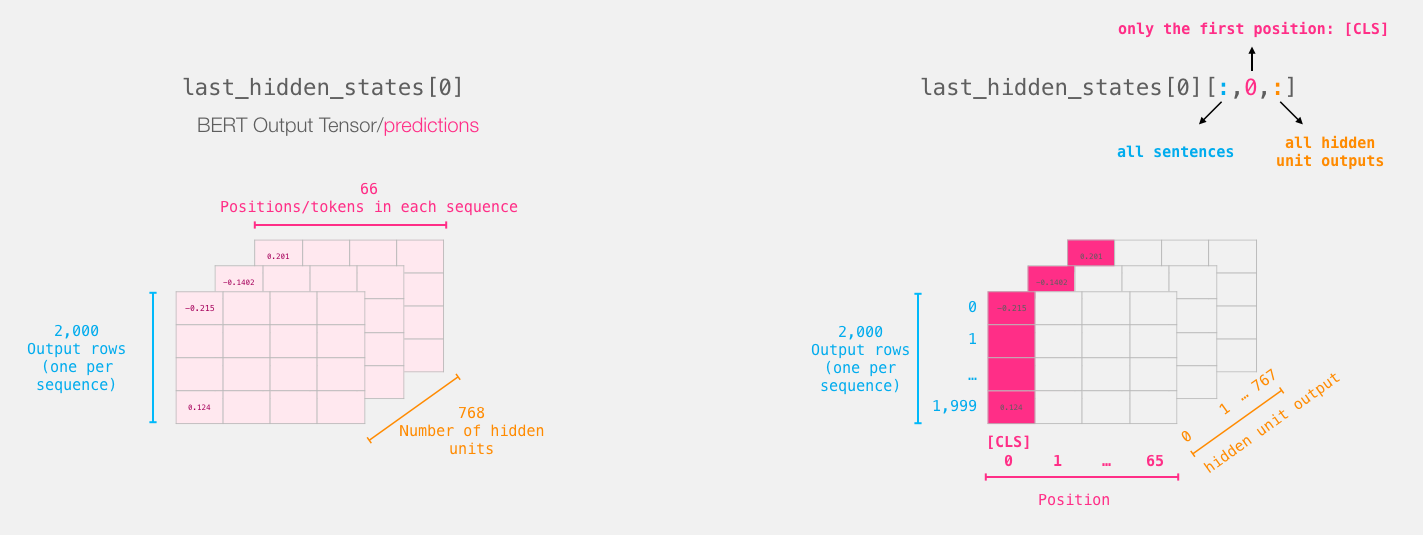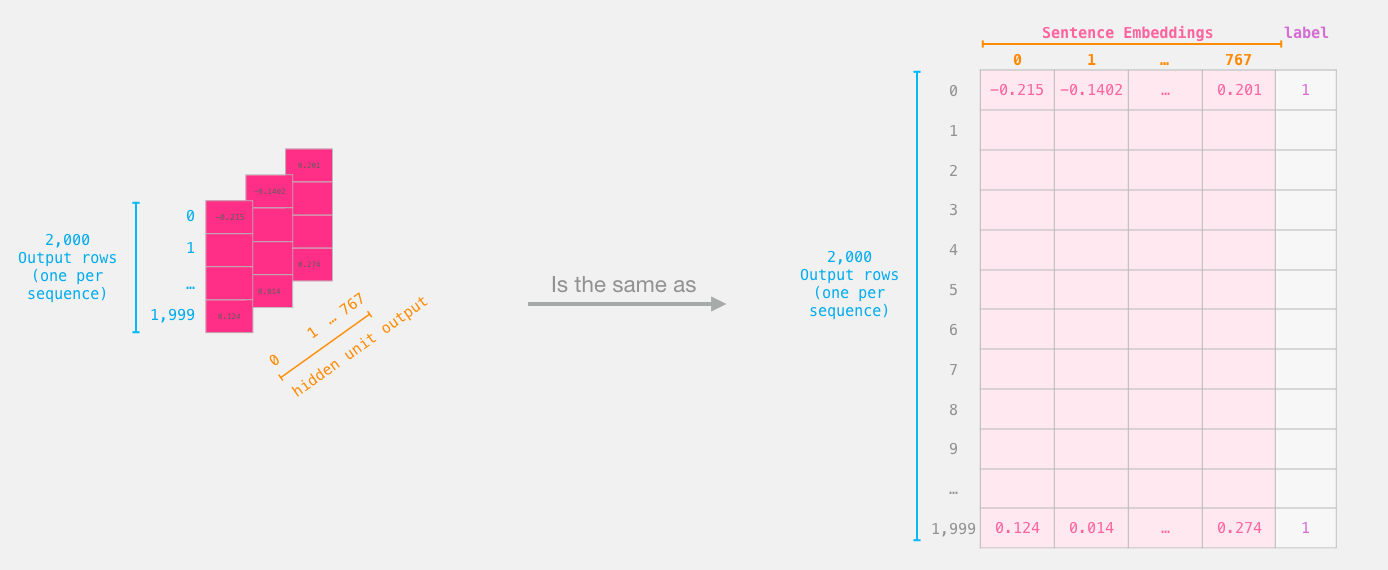

In [ ]:
class NewsModel(nn.Module):
    def __init__(self):
        super(NewsModel, self).__init__()
        conf = transformers.BertConfig()
        conf.output_hidden_states = True
        self.model = transformers.BertModel.from_pretrained('bert-base-uncased', config = conf)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(conf.hidden_size, 5)
        nn.init.xavier_normal_(self.classifier.weight)
    def forward(self, input_ids, attention_masks , token_type_ids):
        out = self.model(input_ids,attention_masks, token_type_ids)
        last_hidden_state_cls = out[0][:,0,:]                                 # This is the output of bert layer like pictures

        output = self.dropout(last_hidden_state_cls)
            
        logits = self.classifier(output)
                
        return logits
            

In [ ]:
def loss_fn(output, predicted ):
    ce_loss = nn.BCEWithLogitsLoss()
    loss = ce_loss(output, predicted)
    return loss

In [ ]:
def flat_accuracy(output, prediction):
    prediction_flat = np.argmax(prediction, axis=1).flatten()
    output_flat = np.argmax(output, axis=1).flatten()
    return np.sum(prediction_flat == output_flat) / len(output_flat)

In [ ]:
def train_model(model, data_loaders, criterion, optimizer, num_epochs, device, flat_accuracy):

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()
            else:
                model.eval()
            losses = []        
            epoch_loss = 0.0
            accuracy = 0.0
            counter = 0.0
            best_accuracy = 0
            dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

            for data in data_loaders[phase]:

                input_ids = data['input_ids'].to(device)
                attention_masks = data['attention_masks'].to(device)
                token_type_ids = data['token_type_ids'].to(device)
                output = data['labels'].to(device, dtype = torch.long)
                

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    



                    prediction = model( input_ids, attention_masks,  token_type_ids)
                    output = torch.max(output.float(), 1)[0]

                    loss = criterion(output,prediction)
                    if phase == 'train':

                        loss.backward()
                        optimizer.step()
                    losses.append(loss.item())

                    prediction = prediction.detach().cpu().numpy()
                    output = output.detach().cpu().numpy()

                    accuracy += flat_accuracy(output, prediction)
                    counter +=1
                    epoch_loss += loss.item() * len(input_ids)
            epoch_loss = epoch_loss /len(data_loaders[phase].dataset)
            epoch_accuracy =accuracy / counter
            if (phase == 'val' and epoch_accuracy > best_accuracy):
                best_model_weights = model.state_dict()
                best_accuracy = epoch_accuracy
            print("Epoch {} - {}- Loss {:.3f} - Accuracy: {:.3f} , number of examples :{}".format(epoch,phase,epoch_loss,epoch_accuracy,len(data_loaders[phase].dataset)))

    return best_model_weights, losses , best_accuracy

In [ ]:
data_loaders = get_data_loader(df, range(100),range(100),text_column = 'text', label_column = 'category',tokenizer = tokenizer)

* These are the model inputs. It shows first batch from data_loader.

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
stop_cnt = 0
model = NewsModel()

for i in data_loaders['train']:
    
    output = i['labels']
    print(i["input_ids"])
    print(i["attention_masks"])
    print(i["token_type_ids"])
    prediction = model(i["input_ids"],i["attention_masks"],i["token_type_ids"]) 
    stop_cnt+=1
    if stop_cnt == 1:
        break
        
output = torch.max(output.float(),1)[0]
prediction = prediction.detach().cpu().numpy()
output = output.detach().cpu().numpy()


* These are the first batch of labels and prediction before training. As you can see the predictions are really bad before training.

In [ ]:
print(output)
print(prediction)

* I cleared the cache to prevent cuda overload, but I still cannot use the higher max length or higher batch size. If anyone has solution, please give advice :)

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
best_accuracy = 0
for fold, (train_index, val_index) in enumerate(skf.split(df, df.category),start = 1):

    print(f"fold :{fold}")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    model = NewsModel()
    model.to(device)
    optimizer = AdamW(model.parameters(), lr = 3e-5)
    data_loaders = get_data_loader(df,train_index, val_index ,tokenizer = tokenizer, batch_size = 64, max_len = 128,text_column = 'cleaned', label_column = 'category')
    criterion = loss_fn
    

    model_weights, losses, accuracy = train_model(model, data_loaders, criterion, optimizer,flat_accuracy=flat_accuracy, num_epochs = 4, device = device)
    
    if accuracy > best_accuracy:
        final_model_weights = model_weights        # This keeps the best model's weights.
        best_accuracy = accuracy

* The model improved from 96% to 98%. 

In [ ]:
print('The best accuracy of the validation dataset is {:.2f}'.format(best_accuracy*100))

* This function is for prediction from unseen dataset.

In [ ]:
def prediction_class(final_model_weights, text):
    batch_test_losses = []
    batch_test_accuracies = []
    best_test_accuracy = 0
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    model = NewsModel()

    model.load_state_dict(final_model_weights)
    class_names = pd.DataFrame(class_name_tokenizers).T
    test_data_loaders = get_test_loader(text, tokenizer, batch_size = 1, max_len = 128, num_workers = 0,text_column = 'cleaned', label_column = 'category')
    for i, data in enumerate(test_data_loaders):

        prediction = model(data['input_ids'], data['attention_masks'], data['token_type_ids'])
        output = data["labels"]
        output =torch.max(output.float(),1)[0]

        prediction = prediction.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
#        print(output)
#        print(prediction)
#        print(text.loc[i,'text'])
#        print("Real output is {}, Prediction is :{}\n".format(text.loc[i,'category'], class_names[class_names[1] == np.argmax(output)].index[0]))
        batch_test_accuracy = flat_accuracy(output, prediction)
        batch_test_accuracies.append(batch_test_accuracy)
        test_accuracy = sum(batch_test_accuracies) / len(batch_test_accuracies)
    return print("Test dataset includes {} texts and the test set accuracy is {:.2f}.".format(len(batch_test_accuracies),test_accuracy))

* We saved the weights of best model and use in the prediction class method.
* You can see the accuracy of the test set. It predicted correctly all test set. It is amazing result.

In [ ]:
prediction_class(final_model_weights, df_test)

* Cuda library's empty_cache() method clears the gpu for pytorch, so in next neural network gpu memory is not gonna be overload.

In [ ]:
torch.cuda.empty_cache()

 # Bert - Tensorflow
* Compared to pytorch, tensorflow process is easier. 
* There is another library to load bert_layer for tensorflow. First bert library needs special data type that is converted by pytorch data_loader, so I loaded by tensorflow hub library.


In [ ]:
tf.keras.backend.clear_session()
import tensorflow_hub as hub

In [ ]:
def build_model(max_len = 128):
    ids = tf.keras.layers.Input(shape = (max_len, ), dtype = tf.int32)
    masks = tf.keras.layers.Input(shape =(max_len,), dtype = tf.int32)
    token_ids = tf.keras.layers.Input(shape =(max_len,), dtype = tf.int32)

    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",  trainable=True)
    pooled_output, sequence_output = bert_layer([ids, masks ,token_ids])

    output = sequence_output[:,0,:]

    out = tf.keras.layers.Dropout(0.5)(output)

    out = tf.keras.layers.Dense(5, activation = 'softmax')(out)

    model = tf.keras.models.Model(inputs = [ids,masks,token_ids], outputs= out)

    optimizer = tf.optimizers.Adam(learning_rate = 3e-5)

    model.compile(loss ='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [ ]:
def encode(df, max_len = 128):

    ids = np.zeros((len(df), max_len), dtype = 'float32')
    masks = np.zeros((len(df), max_len), dtype = 'float32')
    token_ids = np.zeros((len(df), max_len), dtype = 'float32')
    labels = np.zeros((len(df), max_len), dtype = 'float32')

    ids, masks, token_ids, labels=map(list, zip(*df[['text', 'category']].apply(lambda x: processing_data(x.text, x.category,convert_token_ids = False, max_len = max_len), axis = 1)))

    ids = np.array(ids, dtype ='float32')
    masks = np.array(masks, dtype ='float32')
    token_ids = np.array(token_ids, dtype ='float32')
    labels = tf.keras.utils.to_categorical(np.array(labels))
    return ids,masks, token_ids, labels

In [ ]:
skf = StratifiedKFold(n_splits = 4, shuffle = True)

ids, masks, token_ids, labels = encode(df, max_len = 128)

for k , (train_index,val_index) in enumerate(skf.split(ids, labels.argmax(1)), start =1):
    ids_train = ids[train_index,:],
    masks_train = masks[train_index,:]
    token_train = token_ids[train_index,:]
    labels_train = labels[train_index,:]
    ids_val = ids[train_index,:],
    masks_val = masks[train_index,:]
    token_val = token_ids[train_index,:]
    labels_val = labels[train_index,:]
    print("fold :{}".format(k))
    model = build_model()
    history = model.fit((ids_train, masks_train, token_train), labels_train, epochs = 3, verbose = 1, batch_size = 32, validation_data = ((ids_val, masks_val, token_val), labels_val))

* Tensorflow performs better than pytorch. I was expecting similar result, but this result is 2.5% better than pytorch.

In [ ]:
ids_test, masks_test, token_ids_test, labels_test = encode(df_test, max_len = 128)
prediction = model.predict((ids_test, masks_test, token_ids_test))
output = tf.keras.utils.to_categorical(df_test['label'])
test_result = flat_accuracy(output, prediction)
print("The test set includes {} texts and the accuracy is {}".format(len(output), test_result))

# Summary

* This dataset was very clean and there weren't many special characters because these news is written by BBC editors. So, our final accuracy is very high.
* BERT performs almost perfectly in tensorflow model, the validation accuracy is around 99.5%.
* **BERT(Pytorch - Tensorflow) models predicted all 64 unseen News correctly** which is great. However, **in the model with Glove embeddings, test set accuracy was 0.875**.


* PS: I haven't builded many neural networks with PyTorch, so probably, this is the reason of that the accuracy is lower in my Pytorch model than Tensorflow model. Please give me recommendations if you see anything that can improve the model.
* If you like it pelase upvote, thanks.